In [1]:
min=15
print(str(min)+'min')
lag=30
formato='%Y-%m-%d %H:%M:%S'

15min


In [2]:
import codigo
from codigo import utils
from codigo import model_utils

In [3]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

# Importar Dataset depurado

In [4]:
df_Inicial = pd.read_csv(r'dataset/generado/datasetDepurado.csv')

# Revisamos las columnas que contiene el Dataset

In [5]:
df_Inicial.head()

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0


In [6]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             object 
 1   Date           object 
 2   Glucose level  float64
dtypes: float64(1), object(2)
memory usage: 67.9+ MB


### Cambiamos el formato de la columna Date de object a datetime64

In [7]:
df_Inicial['Date']=pd.to_datetime(df_Inicial['Date'])

In [8]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   Date           datetime64[ns]
 2   Glucose level  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ MB


In [9]:
df_Inicial['Date'].min()

Timestamp('2018-01-06 00:31:00')

In [10]:
df_Inicial['Date'].max()

Timestamp('2022-03-20 23:58:00')

In [11]:
df=df_Inicial

In [12]:
features=['Glucose level','hour','min','pod_id','level_id']

In [13]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))
train_share = 0
val_share = 0 
n_ahead=1

# Generación de Dataset General

In [14]:
dfIDPacientesTest = pd.read_csv(r'dataset/generado/IDs_Test.csv')
dfIDPacientesTest

,ID
0,LIB193271
1,LIB193399


In [15]:
dfCopy = df.copy()
dfGen=pd.DataFrame()
strMin=str(min)+'min'
for pacienteID in dfIDPacientesTest['ID']: 
    data=utils.getDataPatient(dfCopy,pacienteID,strMin,True,True)
    data['level_label'] = data['Glucose level'].apply(utils.label_LevelBG) 
    if(len(data['Glucose level'])>=lag):
        dfGen = pd.concat([dfGen, data])

In [16]:
dfGen

,Glucose level,ID,Date,level_label
Date,,,,
2021-02-05 11:45:00,211.0,LIB193358,2021-02-05 11:45:00,hyperglycemia
2021-02-05 12:00:00,218.0,LIB193358,2021-02-05 12:00:00,hyperglycemia
2021-02-05 12:15:00,220.0,LIB193358,2021-02-05 12:15:00,hyperglycemia
2021-02-05 12:30:00,231.0,LIB193358,2021-02-05 12:30:00,hyperglycemia
2021-02-05 12:45:00,246.0,LIB193358,2021-02-05 12:45:00,hyperglycemia
...,...,...,...,...
2022-02-17 08:15:00,137.0,LIB193365,2022-02-17 08:15:00,normal
2022-02-17 08:30:00,177.0,LIB193365,2022-02-17 08:30:00,normal
2022-02-17 08:45:00,198.0,LIB193365,2022-02-17 08:45:00,hyperglycemia


In [17]:
dfGen['Glucose level'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 478281 entries, 2021-02-05 11:45:00 to 2022-02-17 09:15:00
Series name: Glucose level
Non-Null Count   Dtype  
--------------   -----  
297626 non-null  float64
dtypes: float64(1)
memory usage: 7.3 MB


In [18]:
dfGen=dfGen.dropna()
dfGen['Glucose level'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 297626 entries, 2021-02-05 11:45:00 to 2022-02-17 09:15:00
Series name: Glucose level
Non-Null Count   Dtype  
--------------   -----  
297626 non-null  float64
dtypes: float64(1)
memory usage: 4.5 MB


In [19]:
dfPacienteCount= pd.DataFrame(dfGen.ID.value_counts().sort_values(ascending=False))
dfPacienteCount

,ID
LIB193358,15136
LIB193317,14865
LIB193271,14853
LIB193392,13607
LIB193353,13079
LIB193274,11792
LIB193330,11285
LIB193325,11144
LIB193376,10671
LIB193344,10343


<AxesSubplot:ylabel='level_label'>

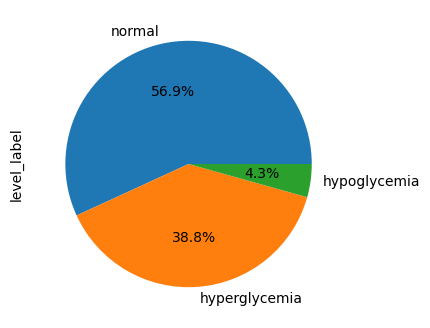

In [20]:
dfGen['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

## Análisis del Paciente 1: ID: LIB193399 

Contiene 1913, se considera que contiene pocos registros

In [21]:
ID_Paciente=ID_Paciente1='LIB193399'
diasP1=[]
especialesP1=[]

In [22]:
dfGen[dfGen['ID'] == ID_Paciente]

,Glucose level,ID,Date,level_label
Date,,,,
2020-09-30 18:15:00,105.0,LIB193399,2020-09-30 18:15:00,normal
2020-09-30 18:30:00,101.0,LIB193399,2020-09-30 18:30:00,normal
2020-09-30 18:45:00,98.0,LIB193399,2020-09-30 18:45:00,normal
2020-09-30 19:00:00,99.0,LIB193399,2020-09-30 19:00:00,normal
2020-09-30 19:15:00,108.0,LIB193399,2020-09-30 19:15:00,normal
...,...,...,...,...
2020-10-20 20:45:00,83.0,LIB193399,2020-10-20 20:45:00,normal
2020-10-20 21:00:00,76.0,LIB193399,2020-10-20 21:00:00,normal
2020-10-20 21:15:00,67.0,LIB193399,2020-10-20 21:15:00,hypoglycemia


<AxesSubplot:ylabel='level_label'>

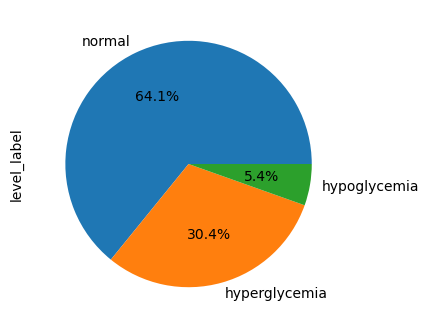

In [23]:
dfGen[dfGen['ID'] == ID_Paciente]['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-09-30 20:30:00
Rango Inicio Objetivo: 2020-10-1 04:00:00
Rango Fin Objetivo   : 2020-10-1 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193399    110
LIB193271     95
LIB193275     89
Name: ID, dtype: int64


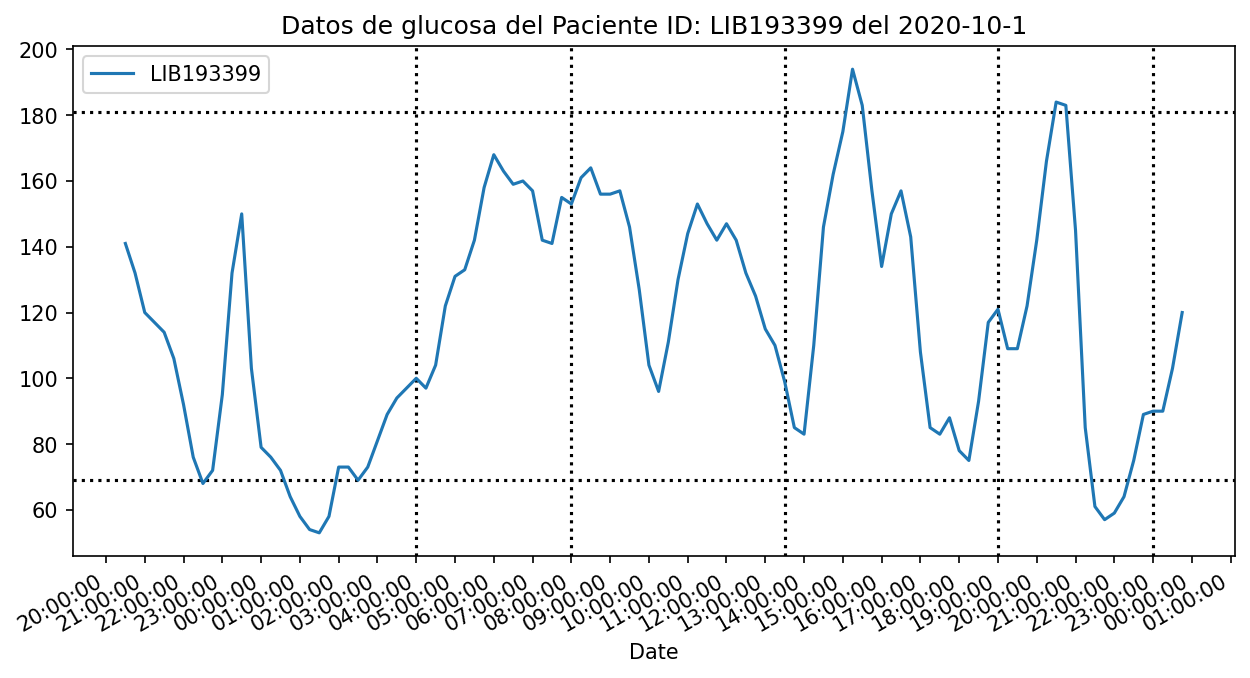

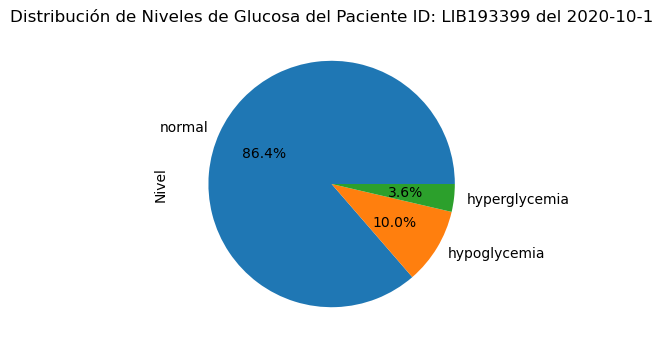

In [24]:
dateObj='2020-10-1'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP1_d1=dfPaciente

### Agregamos eventos especiales de hipoglucemia

Siempre selecciono el 1er evento hipoglucemia que ocurre justo en el cambio

In [25]:
dfPaciente.loc[dateObj+' 21:00:00':dateObj+' 22:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-01 21:00:00,145.0,LIB193399,2020-10-01 21:00:00,normal
2020-10-01 21:15:00,85.0,LIB193399,2020-10-01 21:15:00,normal
2020-10-01 21:30:00,61.0,LIB193399,2020-10-01 21:30:00,hypoglycemia
2020-10-01 21:45:00,57.0,LIB193399,2020-10-01 21:45:00,hypoglycemia
2020-10-01 22:00:00,59.0,LIB193399,2020-10-01 22:00:00,hypoglycemia


In [26]:
especialesP1.append('2020-10-01 21:30:00')

### Selección del Dia 2 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-02 20:30:00
Rango Inicio Objetivo: 2020-10-3 04:00:00
Rango Fin Objetivo   : 2020-10-3 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193399    110
LIB193271    104
Name: ID, dtype: int64


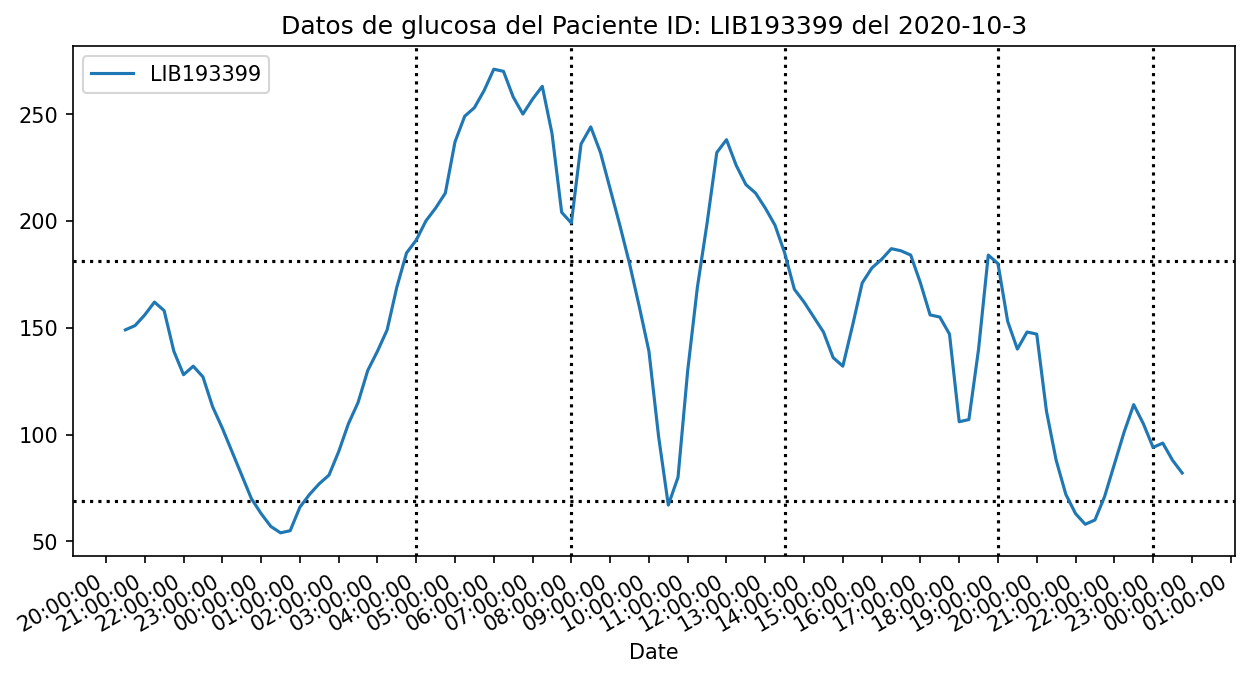

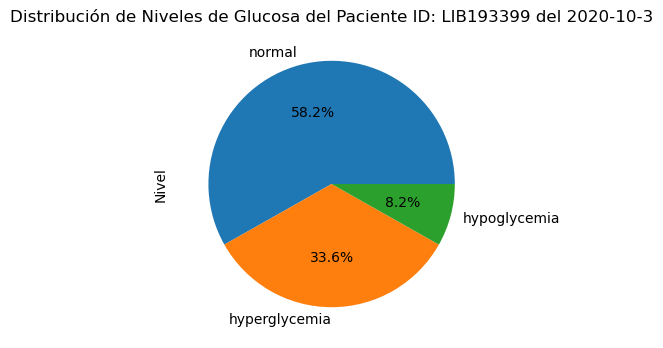

In [27]:
dateObj='2020-10-3'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP1_d2=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [28]:
dfPaciente.loc[dateObj+' 10:00:00':dateObj+' 11:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-03 10:00:00,139.0,LIB193399,2020-10-03 10:00:00,normal
2020-10-03 10:15:00,99.0,LIB193399,2020-10-03 10:15:00,normal
2020-10-03 10:30:00,67.0,LIB193399,2020-10-03 10:30:00,hypoglycemia
2020-10-03 10:45:00,80.0,LIB193399,2020-10-03 10:45:00,normal
2020-10-03 11:00:00,130.0,LIB193399,2020-10-03 11:00:00,normal


In [29]:
especialesP1.append('2020-10-03 10:30:00')

In [30]:
dfPaciente.loc[dateObj+' 20:00:00':dateObj+' 21:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-03 20:00:00,147.0,LIB193399,2020-10-03 20:00:00,normal
2020-10-03 20:15:00,111.0,LIB193399,2020-10-03 20:15:00,normal
2020-10-03 20:30:00,88.0,LIB193399,2020-10-03 20:30:00,normal
2020-10-03 20:45:00,72.0,LIB193399,2020-10-03 20:45:00,normal
2020-10-03 21:00:00,63.0,LIB193399,2020-10-03 21:00:00,hypoglycemia


In [31]:
especialesP1.append('2020-10-03 21:00:00')

### Selección del Dia 3 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-09 20:30:00
Rango Inicio Objetivo: 2020-10-10 04:00:00
Rango Fin Objetivo   : 2020-10-10 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193399    110
LIB193271    107
LIB193275    105
Name: ID, dtype: int64


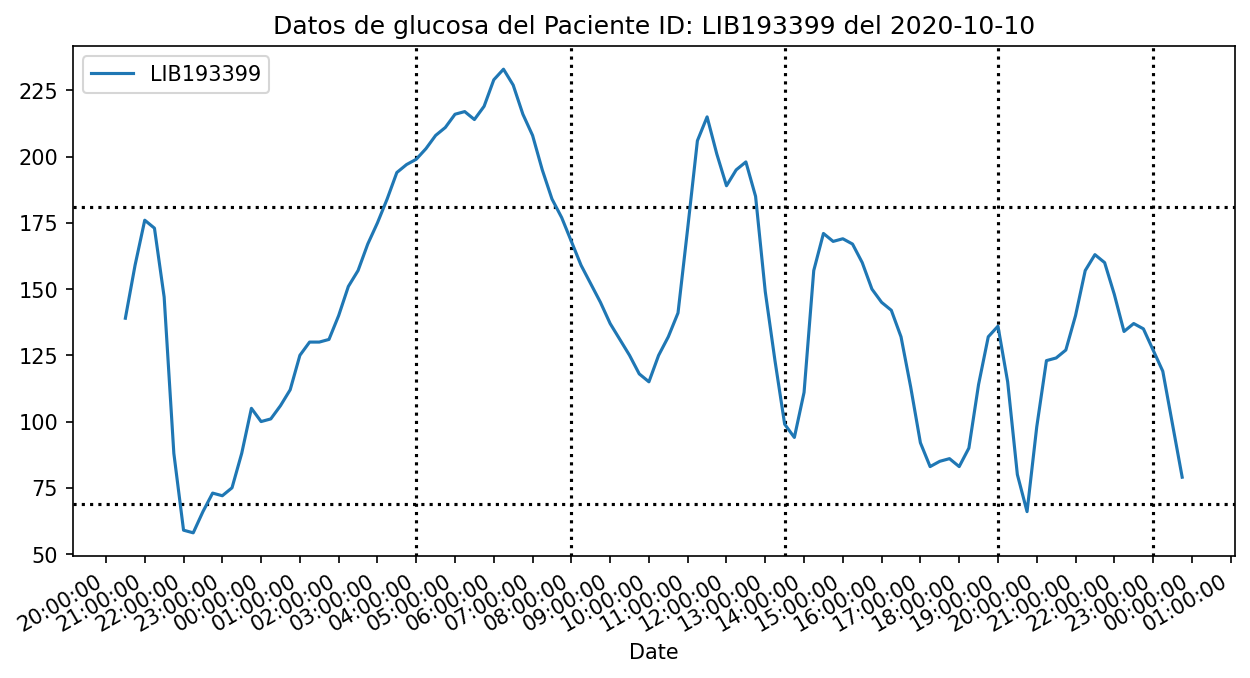

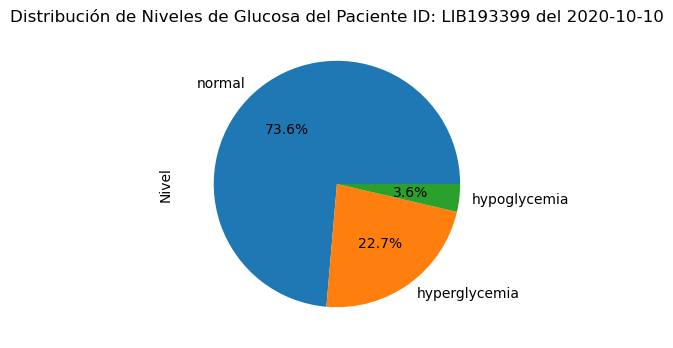

In [32]:
dateObj='2020-10-10'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP1_d3=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [33]:
dfPaciente.loc[dateObj+' 19:00:00':dateObj+' 20:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-10 19:00:00,136.0,LIB193399,2020-10-10 19:00:00,normal
2020-10-10 19:15:00,115.0,LIB193399,2020-10-10 19:15:00,normal
2020-10-10 19:30:00,80.0,LIB193399,2020-10-10 19:30:00,normal
2020-10-10 19:45:00,66.0,LIB193399,2020-10-10 19:45:00,hypoglycemia
2020-10-10 20:00:00,98.0,LIB193399,2020-10-10 20:00:00,normal


In [34]:
especialesP1.append('2020-10-10 19:45:00')

### Selección del Dia 4 del Paciente 1: ID: LIB193399

Fecha Inicio Previo  : 2020-10-11 20:30:00
Rango Inicio Objetivo: 2020-10-12 04:00:00
Rango Fin Objetivo   : 2020-10-12 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193399    110
LIB193271    109
LIB193275    104
Name: ID, dtype: int64


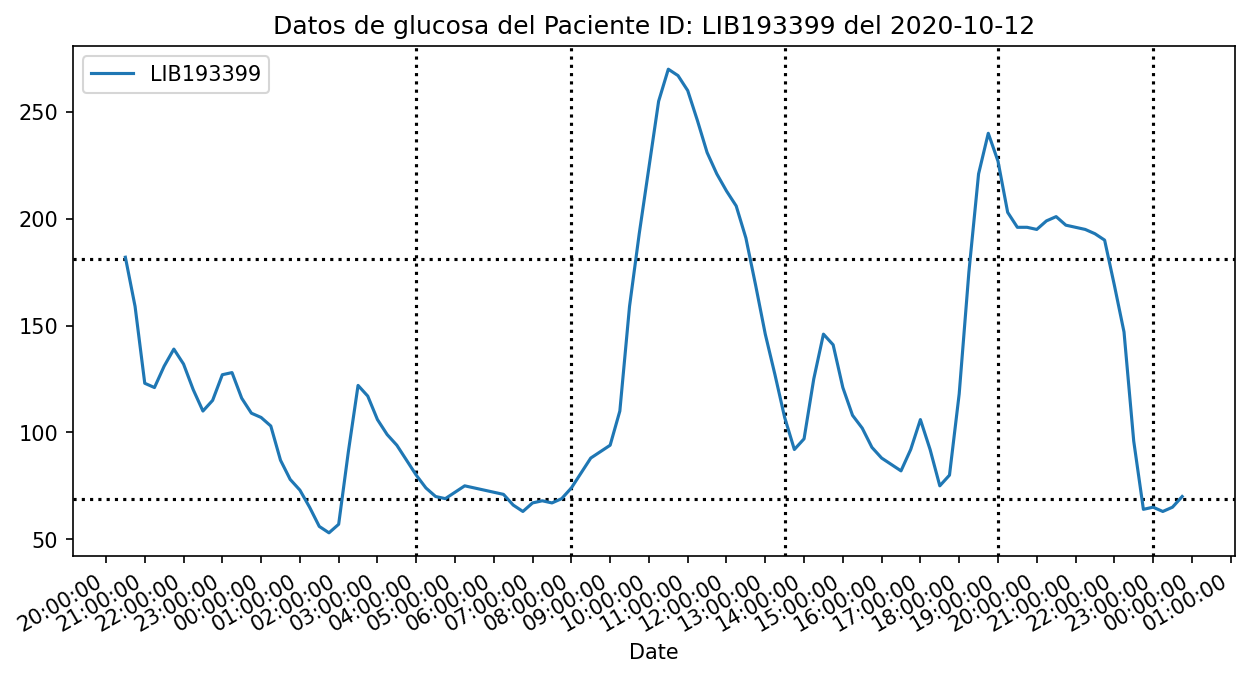

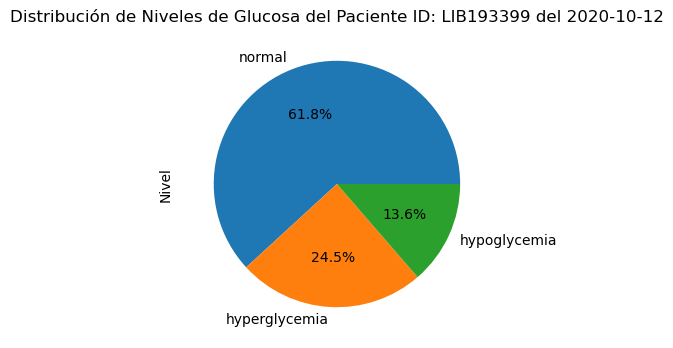

In [35]:
dateObj='2020-10-12'
diasP1.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP1_d4=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [36]:
dfPaciente.loc[dateObj+' 06:00:00':dateObj+' 07:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-12 06:00:00,72.0,LIB193399,2020-10-12 06:00:00,normal
2020-10-12 06:15:00,71.0,LIB193399,2020-10-12 06:15:00,normal
2020-10-12 06:30:00,66.0,LIB193399,2020-10-12 06:30:00,hypoglycemia
2020-10-12 06:45:00,63.0,LIB193399,2020-10-12 06:45:00,hypoglycemia
2020-10-12 07:00:00,67.0,LIB193399,2020-10-12 07:00:00,hypoglycemia


In [37]:
especialesP1.append('2020-10-12 06:30:00')

In [38]:
diasP1

['2020-10-1', '2020-10-3', '2020-10-10', '2020-10-12']

In [39]:
especialesP1

['2020-10-01 21:30:00',
 '2020-10-03 10:30:00',
 '2020-10-03 21:00:00',
 '2020-10-10 19:45:00',
 '2020-10-12 06:30:00']

## Análisis del Paciente 3: ID: LIB193271

Contiene 14853 registros, se considera que contiene bastantes registros 

In [40]:
ID_Paciente=ID_Paciente3='LIB193271'
diasP3=[]
especialesP3=[]

In [41]:
dfGen[dfGen['ID'] == ID_Paciente]

,Glucose level,ID,Date,level_label
Date,,,,
2020-09-24 17:45:00,125.0,LIB193271,2020-09-24 17:45:00,normal
2020-09-24 18:00:00,109.0,LIB193271,2020-09-24 18:00:00,normal
2020-09-24 18:15:00,111.0,LIB193271,2020-09-24 18:15:00,normal
2020-09-24 18:30:00,119.0,LIB193271,2020-09-24 18:30:00,normal
2020-09-24 18:45:00,114.0,LIB193271,2020-09-24 18:45:00,normal
...,...,...,...,...
2022-03-20 22:45:00,172.0,LIB193271,2022-03-20 22:45:00,normal
2022-03-20 23:00:00,172.0,LIB193271,2022-03-20 23:00:00,normal
2022-03-20 23:15:00,179.0,LIB193271,2022-03-20 23:15:00,normal


<AxesSubplot:ylabel='level_label'>

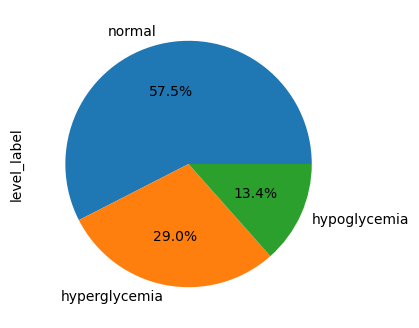

In [42]:
dfGen[dfGen['ID'] == ID_Paciente]['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

### Selección del Dia 1 del Paciente 3: ID: LIB193271

Fecha Inicio Previo  : 2020-09-28 20:30:00
Rango Inicio Objetivo: 2020-09-29 04:00:00
Rango Fin Objetivo   : 2020-09-29 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193271    110
LIB193275    109
Name: ID, dtype: int64


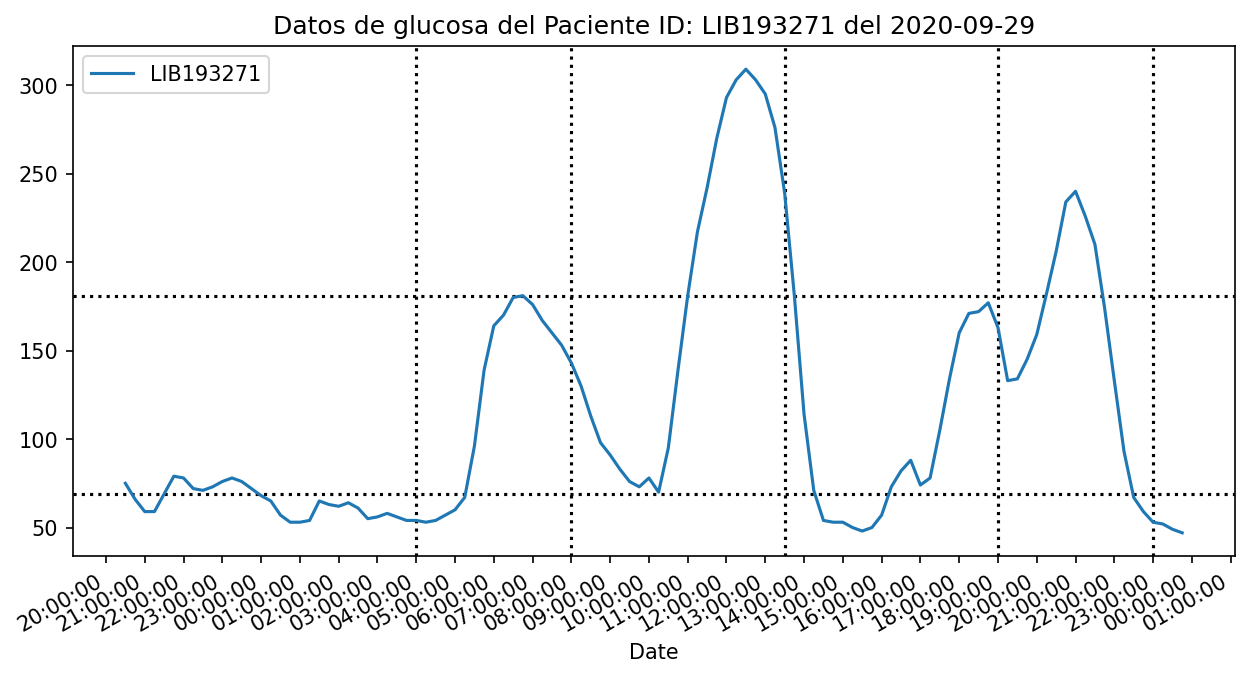

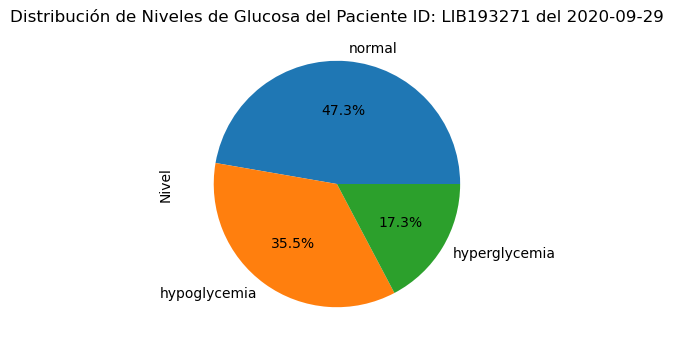

In [43]:
dateObj='2020-09-29'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP3_d1=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [44]:
dfPaciente.loc[dateObj+' 14:00:00':dateObj+' 15:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-09-29 14:00:00,114.0,LIB193271,2020-09-29 14:00:00,normal
2020-09-29 14:15:00,71.0,LIB193271,2020-09-29 14:15:00,normal
2020-09-29 14:30:00,54.0,LIB193271,2020-09-29 14:30:00,hypoglycemia
2020-09-29 14:45:00,53.0,LIB193271,2020-09-29 14:45:00,hypoglycemia
2020-09-29 15:00:00,53.0,LIB193271,2020-09-29 15:00:00,hypoglycemia


In [45]:
especialesP3.append('2020-09-29 14:30:00')

### Selección del Dia 2 del Paciente 3: ID: LIB193271

Fecha Inicio Previo  : 2020-10-10 20:30:00
Rango Inicio Objetivo: 2020-10-11 04:00:00
Rango Fin Objetivo   : 2020-10-11 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193271    110
LIB193399    108
LIB193275     97
Name: ID, dtype: int64


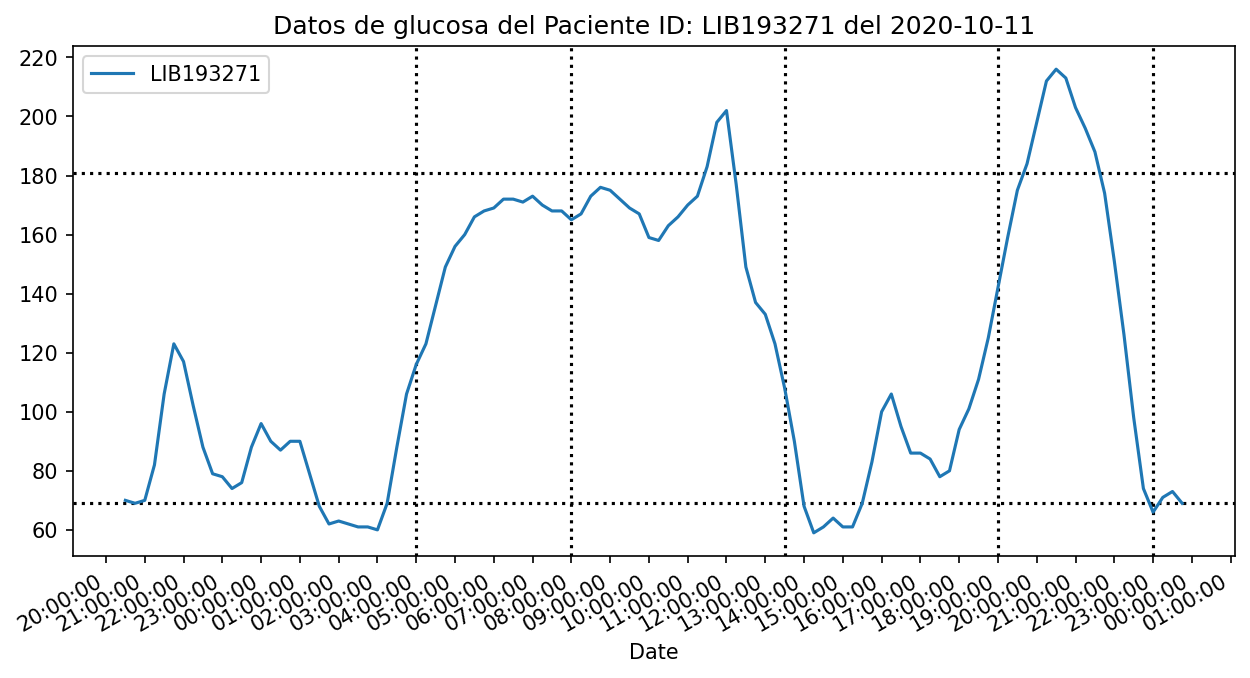

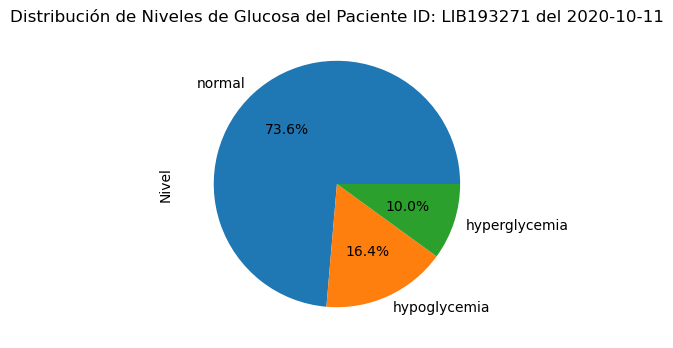

In [46]:
dateObj='2020-10-11'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP3_d2=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [47]:
dfPaciente.loc[dateObj+' 13:00:00':dateObj+' 15:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-11 13:00:00,133.0,LIB193271,2020-10-11 13:00:00,normal
2020-10-11 13:15:00,123.0,LIB193271,2020-10-11 13:15:00,normal
2020-10-11 13:30:00,108.0,LIB193271,2020-10-11 13:30:00,normal
2020-10-11 13:45:00,90.0,LIB193271,2020-10-11 13:45:00,normal
2020-10-11 14:00:00,68.0,LIB193271,2020-10-11 14:00:00,hypoglycemia
2020-10-11 14:15:00,59.0,LIB193271,2020-10-11 14:15:00,hypoglycemia
2020-10-11 14:30:00,61.0,LIB193271,2020-10-11 14:30:00,hypoglycemia
2020-10-11 14:45:00,64.0,LIB193271,2020-10-11 14:45:00,hypoglycemia
2020-10-11 15:00:00,61.0,LIB193271,2020-10-11 15:00:00,hypoglycemia


In [48]:
especialesP3.append('2020-10-11 14:00:00')

### Selección del Dia 3 del Paciente 3: ID: LIB193271

Fecha Inicio Previo  : 2020-10-12 20:30:00
Rango Inicio Objetivo: 2020-10-13 04:00:00
Rango Fin Objetivo   : 2020-10-13 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193271    110
LIB193275    109
LIB193399    109
Name: ID, dtype: int64


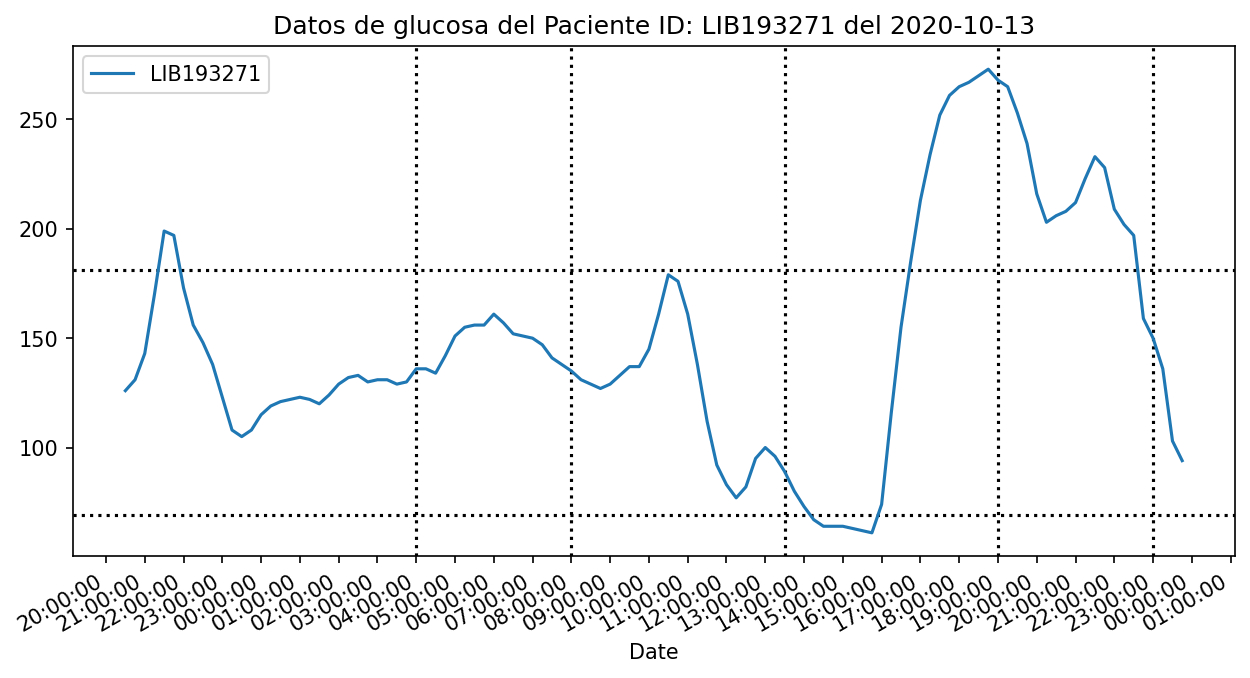

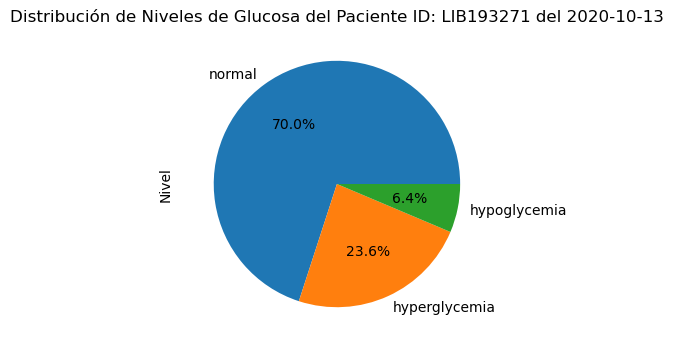

In [49]:
dateObj='2020-10-13'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP3_d3=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [50]:
dfPaciente.loc[dateObj+' 14:00:00':dateObj+' 15:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-13 14:00:00,73.0,LIB193271,2020-10-13 14:00:00,normal
2020-10-13 14:15:00,67.0,LIB193271,2020-10-13 14:15:00,hypoglycemia
2020-10-13 14:30:00,64.0,LIB193271,2020-10-13 14:30:00,hypoglycemia
2020-10-13 14:45:00,64.0,LIB193271,2020-10-13 14:45:00,hypoglycemia
2020-10-13 15:00:00,64.0,LIB193271,2020-10-13 15:00:00,hypoglycemia


In [51]:
especialesP3.append('2020-10-13 14:15:00')

### Selección del Dia 4 del Paciente 3: ID: LIB193271

Fecha Inicio Previo  : 2020-10-13 20:30:00
Rango Inicio Objetivo: 2020-10-14 04:00:00
Rango Fin Objetivo   : 2020-10-14 23:59:59
Cantidad de pacientes y eventos de ese dia
LIB193271    110
LIB193275    106
LIB193399    100
Name: ID, dtype: int64


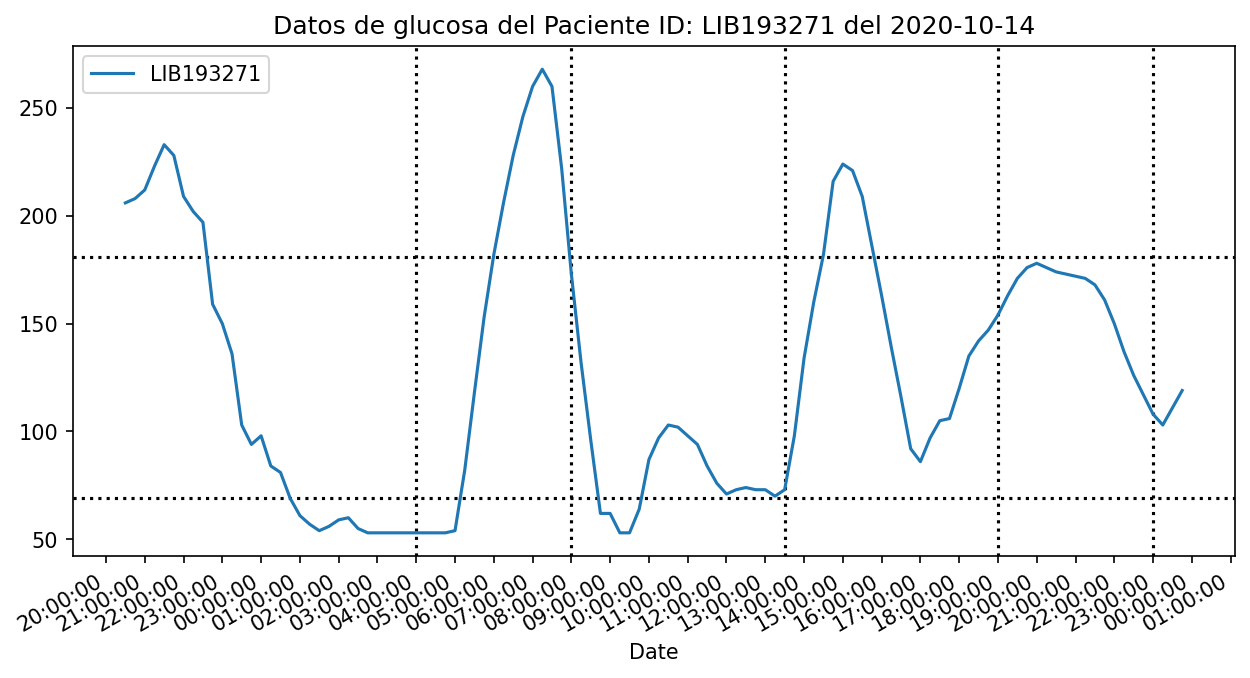

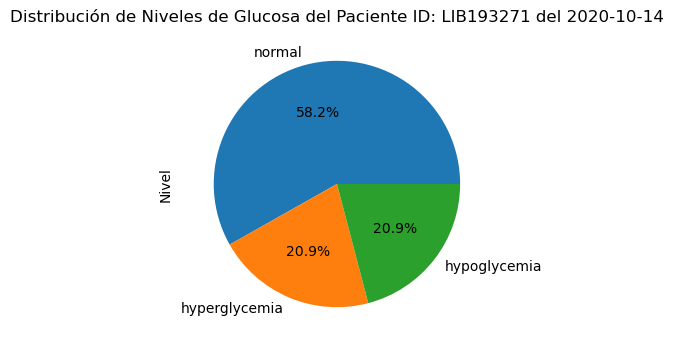

In [52]:
dateObj='2020-10-14'
diasP3.append(dateObj)
    
ObjRangeDateStart=dateObj+' 04:00:00';
ObjRangeDateEnd=dateObj+' 23:59:59';
DateObjStart=utils.restarMinutos(ObjRangeDateStart,formato,min*lag)
print('Fecha Inicio Previo  :',DateObjStart)
print('Rango Inicio Objetivo:',ObjRangeDateStart)
print('Rango Fin Objetivo   :',ObjRangeDateEnd)
df_rango=dfGen.loc[DateObjStart:ObjRangeDateEnd]
print('Cantidad de pacientes y eventos de ese dia')
print(df_rango['ID'].value_counts())


array_ID_Paciente=[ID_Paciente]

dfPaciente=utils.genDataset(df_rango,array_ID_Paciente,min,True,True)  
utils.plotDayAllPatients(dfPaciente,array_ID_Paciente,'Datos de glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,plt,dateObj)

dfPaciente['Nivel'] = dfPaciente['Glucose level'].apply(utils.label_LevelBG) 
dfPaciente['Nivel'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa del Paciente ID: '+ID_Paciente +' del '+dateObj,y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()
dfP3_d4=dfPaciente

### Agregamos eventos especiales de hipoglucemia

In [53]:
dfPaciente.loc[dateObj+' 08:00:00':dateObj+' 09:00:00']

,Glucose level,ID,Date,Nivel
Date,,,,
2020-10-14 08:00:00,173.0,LIB193271,2020-10-14 08:00:00,normal
2020-10-14 08:15:00,132.0,LIB193271,2020-10-14 08:15:00,normal
2020-10-14 08:30:00,96.0,LIB193271,2020-10-14 08:30:00,normal
2020-10-14 08:45:00,62.0,LIB193271,2020-10-14 08:45:00,hypoglycemia
2020-10-14 09:00:00,62.0,LIB193271,2020-10-14 09:00:00,hypoglycemia


In [54]:
especialesP3.append('2020-10-14 08:45:00')

In [55]:
diasP3

['2020-09-29', '2020-10-11', '2020-10-13', '2020-10-14']

In [56]:
especialesP3

['2020-09-29 14:30:00',
 '2020-10-11 14:00:00',
 '2020-10-13 14:15:00',
 '2020-10-14 08:45:00']

## Unimos los dataset de los 4 dias seleccionados de cada paciente

In [57]:
dfP1 = pd.concat([dfP1_d1,dfP1_d2,dfP1_d3,dfP1_d4])
#dfP2 = pd.concat([dfP2_d1,dfP2_d2,dfP2_d3,dfP2_d4])
dfP3 = pd.concat([dfP3_d1,dfP3_d2,dfP3_d3,dfP3_d4])

# Generación de dataset de eventos para pruebas

In [58]:
gen_X=np.reshape([], (0, lag, len(features)))
gen_Y=np.reshape([], (0,1))

## Prueba de recolección de los valores a predecir a las 4am

Hay que recordar que solo necesitamos 30 muestras hacia atras del objetivo, es decir 30*15min=450min o 7.5 horas antes

In [59]:
hora=' 04:00:00'
DateObj=diasP1[0]+hora
print(DateObj)
DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
print(DateObjStart)
df_rango=dfP1.loc[DateObjStart:DateObj]
print(len(df_rango[df_rango['ID'] == ID_Paciente1]))

2020-10-1 04:00:00
2020-09-30 20:30:00
31


## Probamos como se ven los datos del paciente

In [60]:
df_rango[df_rango['ID'] == ID_Paciente1]

,Glucose level,ID,Date,Nivel
Date,,,,
2020-09-30 20:30:00,141.0,LIB193399,2020-09-30 20:30:00,normal
2020-09-30 20:45:00,132.0,LIB193399,2020-09-30 20:45:00,normal
2020-09-30 21:00:00,120.0,LIB193399,2020-09-30 21:00:00,normal
2020-09-30 21:15:00,117.0,LIB193399,2020-09-30 21:15:00,normal
2020-09-30 21:30:00,114.0,LIB193399,2020-09-30 21:30:00,normal
2020-09-30 21:45:00,106.0,LIB193399,2020-09-30 21:45:00,normal
2020-09-30 22:00:00,92.0,LIB193399,2020-09-30 22:00:00,normal
2020-09-30 22:15:00,76.0,LIB193399,2020-09-30 22:15:00,normal
2020-09-30 22:30:00,68.0,LIB193399,2020-09-30 22:30:00,hypoglycemia


## Probamos como se ven los datos que debe generar para entrenamiento

In [61]:
select_data=df_rango.to_numpy()        
        
X, Y = model_utils.create_X_Y(select_data, lag, n_ahead=1)

In [62]:
X[0]

array([[141.0, 'LIB193399', Timestamp('2020-09-30 20:30:00'), 'normal'],
       [132.0, 'LIB193399', Timestamp('2020-09-30 20:45:00'), 'normal'],
       [120.0, 'LIB193399', Timestamp('2020-09-30 21:00:00'), 'normal'],
       [117.0, 'LIB193399', Timestamp('2020-09-30 21:15:00'), 'normal'],
       [114.0, 'LIB193399', Timestamp('2020-09-30 21:30:00'), 'normal'],
       [106.0, 'LIB193399', Timestamp('2020-09-30 21:45:00'), 'normal'],
       [92.0, 'LIB193399', Timestamp('2020-09-30 22:00:00'), 'normal'],
       [76.0, 'LIB193399', Timestamp('2020-09-30 22:15:00'), 'normal'],
       [68.0, 'LIB193399', Timestamp('2020-09-30 22:30:00'),
        'hypoglycemia'],
       [72.0, 'LIB193399', Timestamp('2020-09-30 22:45:00'), 'normal'],
       [95.0, 'LIB193399', Timestamp('2020-09-30 23:00:00'), 'normal'],
       [132.0, 'LIB193399', Timestamp('2020-09-30 23:15:00'), 'normal'],
       [150.0, 'LIB193399', Timestamp('2020-09-30 23:30:00'), 'normal'],
       [103.0, 'LIB193399', Timestamp('202

In [63]:
Y[0]

array([100.0], dtype=object)

## Preparamos los parametros y generamos el dataset para este evento

In [64]:
dfGenResp,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(df_rango,features,[ID_Paciente1],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,False)

In [65]:
array_Ytrain,array_Yval,array_Ytest

(array([], shape=(0, 1), dtype=float64),
 array([], shape=(0, 1), dtype=float64),
 array([[0.13043478]]))

In [66]:
scalerGlucosa.inverse_transform(array_Ytest)

array([[100.]])

In [67]:
array_Xtest.shape

(1, 30, 5)

## Acumulamos los datos en los array de entrenamiento

In [68]:
gen_X=np.concatenate((gen_X,array_Xtest))
gen_Y=np.concatenate((gen_Y,array_Ytest))
print(gen_X.shape)
print(gen_Y.shape)

(1, 30, 5)
(1, 1)


In [69]:
gen_X=np.reshape([], (0, lag, len(features)))
gen_Y=np.reshape([], (0,1))

## Recolección de los eventos de forma automática

In [70]:
gen_XP1=np.reshape([], (0, lag, len(features)))
gen_YP1=np.reshape([], (0,1))

gen_XP2=np.reshape([], (0, lag, len(features)))
gen_YP2=np.reshape([], (0,1))

gen_XP3=np.reshape([], (0, lag, len(features)))
gen_YP3=np.reshape([], (0,1))

### Eventos fijos

In [71]:
eventosP3=[]
eventosP2=[]
eventosP1=[]
eventosFijos=[' 04:00:00',' 08:00:00',' 13:30:00',' 19:00:00',' 23:00:00']
for evento in eventosFijos: 
    print('Paciente 1')
    for dia in diasP1: 
        DateObj=dia+evento
        eventosP1.append(DateObj)
        print(DateObj)
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
        df_rango=dfP1.loc[DateObjStart:DateObj]

        dfGenResp,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(df_rango,features,[ID_Paciente1],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,False)
        gen_XP1=np.concatenate((gen_XP1,array_Xtest))
        gen_YP1=np.concatenate((gen_YP1,array_Ytest))

    print('Paciente 3')
    for dia in diasP3: 
        DateObj=dia+evento
        eventosP3.append(DateObj)
        print(DateObj)
        DateObjStart=utils.restarMinutos(DateObj,formato,min*lag) 
        df_rango=dfP3.loc[DateObjStart:DateObj]

        dfGenResp,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(df_rango,features,[ID_Paciente3],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,False)
        gen_XP3=np.concatenate((gen_XP3,array_Xtest))
        gen_YP3=np.concatenate((gen_YP3,array_Ytest))

Paciente 1
2020-10-1 04:00:00
2020-10-3 04:00:00
2020-10-10 04:00:00
2020-10-12 04:00:00
Paciente 3
2020-09-29 04:00:00
2020-10-11 04:00:00
2020-10-13 04:00:00
2020-10-14 04:00:00
Paciente 1
2020-10-1 08:00:00
2020-10-3 08:00:00
2020-10-10 08:00:00
2020-10-12 08:00:00
Paciente 3
2020-09-29 08:00:00
2020-10-11 08:00:00
2020-10-13 08:00:00
2020-10-14 08:00:00
Paciente 1
2020-10-1 13:30:00
2020-10-3 13:30:00
2020-10-10 13:30:00
2020-10-12 13:30:00
Paciente 3
2020-09-29 13:30:00
2020-10-11 13:30:00
2020-10-13 13:30:00
2020-10-14 13:30:00
Paciente 1
2020-10-1 19:00:00
2020-10-3 19:00:00
2020-10-10 19:00:00
2020-10-12 19:00:00
Paciente 3
2020-09-29 19:00:00
2020-10-11 19:00:00
2020-10-13 19:00:00
2020-10-14 19:00:00
Paciente 1
2020-10-1 23:00:00
2020-10-3 23:00:00
2020-10-10 23:00:00
2020-10-12 23:00:00
Paciente 3
2020-09-29 23:00:00
2020-10-11 23:00:00
2020-10-13 23:00:00
2020-10-14 23:00:00


In [72]:
gen_X=np.concatenate((gen_XP1,gen_XP2,gen_XP3))

In [73]:
gen_X.shape

(40, 30, 5)

In [74]:
gen_Y=np.concatenate((gen_YP1,gen_YP2,gen_YP3))

In [75]:
gen_Y.shape

(40, 1)

In [76]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(gen_Y),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult

,Glucose level,Nivel
0,100.0,normal
1,191.0,hyperglycemia
2,199.0,hyperglycemia
3,80.0,normal
4,153.0,normal
5,199.0,hyperglycemia
6,168.0,normal
7,74.0,normal
8,99.0,normal
9,185.0,hyperglycemia


In [77]:
dfResult['Nivel'].value_counts()

normal           28
hyperglycemia     7
hypoglycemia      5
Name: Nivel, dtype: int64

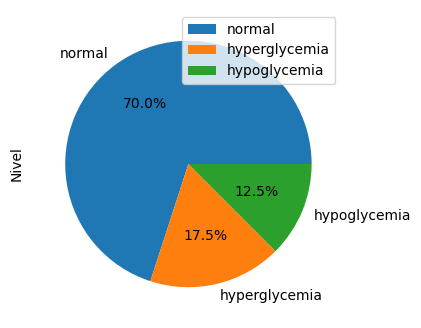

In [78]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

### Eventos especiales

In [79]:
print('Paciente 1')
for evento in especialesP1:
    DateObj=evento
    print(DateObj)
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP1.loc[DateObjStart:DateObj]

    dfGenResp,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(df_rango,features,[ID_Paciente1],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,False)
    gen_XP1=np.concatenate((gen_XP1,array_Xtest))
    gen_YP1=np.concatenate((gen_YP1,array_Ytest))

print('Paciente 3')
for evento in especialesP3: 
    DateObj=evento
    print(DateObj)
    DateObjStart=utils.restarMinutos(DateObj,formato,min*lag)
    df_rango=dfP3.loc[DateObjStart:DateObj]

    dfGenResp,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(df_rango,features,[ID_Paciente3],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,False)
    gen_XP3=np.concatenate((gen_XP3,array_Xtest))
    gen_YP3=np.concatenate((gen_YP3,array_Ytest))
    

Paciente 1
2020-10-01 21:30:00
2020-10-03 10:30:00
2020-10-03 21:00:00
2020-10-10 19:45:00
2020-10-12 06:30:00
Paciente 3
2020-09-29 14:30:00
2020-10-11 14:00:00
2020-10-13 14:15:00
2020-10-14 08:45:00


In [80]:
dfResult=pd.DataFrame(scalerGlucosa.inverse_transform(gen_Y),columns=['Glucose level'])
dfResult['Nivel'] = dfResult['Glucose level'].apply(utils.label_LevelBG)   
dfResult['Nivel'].value_counts()

normal           28
hyperglycemia     7
hypoglycemia      5
Name: Nivel, dtype: int64

In [1]:
gen_Y

NameError: name 'gen_Y' is not defined

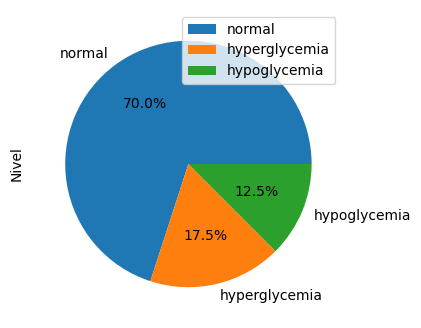

In [81]:
dfResult['Nivel'].value_counts().plot.pie(y='level_label',legend=True,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

In [114]:
with open('dataset/generado/paciente1/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP1)

In [112]:
with open('dataset/generado/paciente1/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP1)

In [113]:
gen_XP1.shape

(25, 30, 5)

In [85]:
gen_YP1.shape

(25, 1)

In [86]:
with open('dataset/generado/paciente2/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP2)

In [87]:
with open('dataset/generado/paciente2/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP2)

In [88]:
gen_XP2.shape

(0, 30, 5)

In [89]:
gen_YP2.shape

(0, 1)

In [90]:
with open('dataset/generado/paciente3/eventos_X.npy', 'wb') as f:
    np.save(f, gen_XP3)

In [91]:
with open('dataset/generado/paciente3/eventos_Y.npy', 'wb') as f:
    np.save(f, gen_YP3)

In [92]:
gen_XP3.shape

(24, 30, 5)

In [93]:
gen_YP3.shape

(24, 1)

# Generar DataSet de cada Paciente

In [94]:
train_share = 0.9
val_share = 0.95 

## Paciente 1

In [95]:
ID_Paciente1

'LIB193399'

In [96]:
dfPaciente1=utils.getDataPatient(dfGen,ID_Paciente1,strMin,True,True,resample=False)
dfPaciente1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1913 entries, 2020-09-30 18:15:00 to 2020-10-20 21:45:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Glucose level  1913 non-null   float64       
 1   ID             1913 non-null   object        
 2   Date           1913 non-null   datetime64[ns]
 3   level_label    1913 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 74.7+ KB


In [97]:
for evento in eventosP1:
    dfPaciente1=dfPaciente1.drop(pd.Timestamp(evento))
for evento in especialesP1:
    dfPaciente1=dfPaciente1.drop(pd.Timestamp(evento))
dfPaciente1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1888 entries, 2020-09-30 18:15:00 to 2020-10-20 21:45:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Glucose level  1888 non-null   float64       
 1   ID             1888 non-null   object        
 2   Date           1888 non-null   datetime64[ns]
 3   level_label    1888 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 73.8+ KB


In [98]:
dfP1Return,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfPaciente1,features,[ID_Paciente1],15,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True)

In [110]:
with open('dataset/generado/paciente1/array_Xtrain.npy', 'wb') as f:
    np.save(f, array_Xtrain)
len(array_Ytrain)

1619

In [100]:
with open('dataset/generado/paciente1/array_Ytrain.npy', 'wb') as f:
    np.save(f, array_Ytrain)
len(array_Ytrain)

1619

In [101]:
with open('dataset/generado/paciente1/array_Xval.npy', 'wb') as f:
    np.save(f, array_Xval)
len(array_Xval)

190

In [102]:
with open('dataset/generado/paciente1/array_Yval.npy', 'wb') as f:
    np.save(f, array_Yval)
len(array_Yval)

190

In [103]:
with open('dataset/generado/paciente1/array_Xtest.npy', 'wb') as f:
    np.save(f, array_Xtest)
len(array_Xtest)

96

In [104]:
with open('dataset/generado/paciente1/array_Ytest.npy', 'wb') as f:
    np.save(f, array_Ytest)
len(array_Ytest)

96

In [105]:
dfP1Return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1935 entries, 2020-09-30 18:15:00 to 2020-10-20 21:45:00
Freq: 15T
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Glucose level  1935 non-null   float64
 1   hour           1935 non-null   float64
 2   min            1935 non-null   float64
 3   pod_id         1935 non-null   float64
 4   level_id       1935 non-null   float64
dtypes: float64(5)
memory usage: 90.7 KB


In [106]:
array_Xtest[50]

array([[0.38913043, 0.13043478, 0.        , 1.        , 1.        ],
       [0.39565217, 0.13043478, 0.25423729, 1.        , 1.        ],
       [0.40217391, 0.13043478, 0.50847458, 1.        , 1.        ],
       [0.41521739, 0.13043478, 0.76271186, 1.        , 1.        ],
       [0.44782609, 0.17391304, 0.        , 1.        , 1.        ],
       [0.48478261, 0.17391304, 0.25423729, 1.        , 1.        ],
       [0.48695652, 0.17391304, 0.50847458, 1.        , 1.        ],
       [0.47608696, 0.17391304, 0.76271186, 1.        , 1.        ],
       [0.47173913, 0.2173913 , 0.        , 0.        , 1.        ],
       [0.47391304, 0.2173913 , 0.25423729, 0.        , 1.        ],
       [0.47826087, 0.2173913 , 0.50847458, 0.        , 1.        ],
       [0.4673913 , 0.2173913 , 0.76271186, 0.        , 1.        ],
       [0.45652174, 0.26086957, 0.        , 0.        , 1.        ],
       [0.44347826, 0.26086957, 0.25423729, 0.        , 0.5       ],
       [0.43043478, 0.26086957, 0.

In [107]:
dfP1Return.loc[eventosP1[0]]

Glucose level    0.123913
hour             0.173913
min              0.000000
pod_id           1.000000
level_id         0.500000
Name: 2020-10-01 04:00:00, dtype: float64

In [108]:
utils.transformScaler(dfP1.loc[eventosP1[0]]['Glucose level'],scalerGlucosa)

0.13043478260869565